In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd

from tqdm import tqdm
from countryinfo import CountryInfo
from matplotlib import pyplot as plt

from utils import *

plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 16})

# Useful Functions

In [2]:
def plot_corr_matrix(df, item):
    fig, ax = plt.subplots(figsize=(10, 7.5))
    sns.heatmap(df[df['Item'] == item].corr(), ax=ax, square=True, annot=True,
                cmap=sns.diverging_palette(220, 20, as_cmap=True), vmin=-1, vmax=1)
    ax.set_title("Correlation Matrix for {}".format(item))
    plt.plot()

In [3]:
def plot_pairplot(df, item):
    plt.rcParams.update({'font.size': 12})
    g = sns.pairplot(df[df['Item'] == item], diag_kind='kde')
    g.fig.suptitle("Pair Plot for {}".format(item))
    plt.plot()
    plt.rcParams.update({'font.size': 16})

In [4]:
def plot_bar_statistics(stat, ylabel, title, item='Potatoes', p=0, q=0, n=5, m=5, x=1, y=1):
    filtered_processed_cy = aug_processed_cy[aug_processed_cy['Item'] == item]
    sorted_processed_cy = filtered_processed_cy.sort_values(stat, ascending=False)
    plt.figure(figsize=(10, 5.5))
    plt.bar(list(sorted_processed_cy['Area'][p:p+n:x]) + [''] + list(sorted_processed_cy['Area'][::-1][q:q+m*y:y])[::-1],
            list(sorted_processed_cy[stat][p:p+n:x]) + [0] + list(sorted_processed_cy[stat][::-1][q:q+m*y:y])[::-1],
            width=0.5)
    plt.xticks(rotation=50)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Preprocessing

## The Raw Dataset

In [5]:
# Read the dataset CSV
cy = pd.read_csv('data/yield.csv', index_col=0)
print("Number of Countries: {}".format(len(cy['Area'].unique())))
print("Number of Vegetables: {}".format(len(cy['Item'].unique())))
cy

Number of Countries: 101
Number of Vegetables: 10


,Area,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Maize,1990,36613,1485.0,121.00,16.37
1,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
2,Albania,"Rice, paddy",1990,23333,1485.0,121.00,16.37
3,Albania,Sorghum,1990,12500,1485.0,121.00,16.37
4,Albania,Soybeans,1990,7000,1485.0,121.00,16.37
...,...,...,...,...,...,...,...
28237,Zimbabwe,"Rice, paddy",2013,22581,657.0,2550.07,19.76
28238,Zimbabwe,Sorghum,2013,3066,657.0,2550.07,19.76
28239,Zimbabwe,Soybeans,2013,13142,657.0,2550.07,19.76
28240,Zimbabwe,Sweet potatoes,2013,22222,657.0,2550.07,19.76


In [6]:
# Keep only Potatoes and Wheat as crops, and rename features
processed_cy = cy[cy['Item'].isin(['Potatoes', 'Wheat'])].sort_values(['Area', 'Item', 'Year'])
processed_cy = processed_cy.reset_index(drop=True)
processed_cy = processed_cy.rename(columns={'average_rain_fall_mm_per_year': 'avg_rain_mm_per_year'})
processed_cy

,Area,Item,Year,hg/ha_yield,avg_rain_mm_per_year,pesticides_tonnes,avg_temp
0,Albania,Potatoes,1990,66667,1485.0,121.00,16.37
1,Albania,Potatoes,1991,77818,1485.0,121.00,15.36
2,Albania,Potatoes,1992,82920,1485.0,121.00,16.06
3,Albania,Potatoes,1993,98446,1485.0,121.00,16.05
4,Albania,Potatoes,1994,81404,1485.0,201.00,16.96
...,...,...,...,...,...,...,...
8128,Zimbabwe,Wheat,2009,30000,657.0,3269.99,20.52
8129,Zimbabwe,Wheat,2010,27681,657.0,3305.17,21.17
8130,Zimbabwe,Wheat,2011,26274,657.0,3340.35,20.78
8131,Zimbabwe,Wheat,2012,24420,657.0,3375.53,20.52


## Normalize features

The _pesticides tonnes_ features need to be normalized with respect to the area (in hectars) of the harvestable area of each country in order to be meaningful. In this way, we replace that feature with the _pesticides tonnes per hectar_ feature.

In [7]:
# Read the CSV about harvestable area information
yield_area = pd.read_csv('data/yield_area.csv')
yield_area

,Area,Year,Ha
0,Afghanistan,1990,2584292
1,Afghanistan,1991,2747650
2,Afghanistan,1992,2643681
3,Afghanistan,1993,3037267
4,Afghanistan,1994,3163191
...,...,...,...
4771,Zimbabwe,2009,2898779
4772,Zimbabwe,2010,2876337
4773,Zimbabwe,2011,3039757
4774,Zimbabwe,2012,2942310


In [8]:
# Normalize pesticides usage
processed_cy = processed_cy.merge(yield_area, on=['Area', 'Year'], how='inner')
processed_cy['pesticides_tonnes'] = 1000.0 * processed_cy['pesticides_tonnes'] / processed_cy['Ha']
processed_cy = processed_cy.rename(columns={'pesticides_tonnes': 'pesticides_kg_per_ha'})
processed_cy = processed_cy.drop(columns='Ha')
processed_cy

,Area,Item,Year,hg/ha_yield,avg_rain_mm_per_year,pesticides_kg_per_ha,avg_temp
0,Albania,Potatoes,1990,66667,1485.0,0.225640,16.37
1,Albania,Wheat,1990,30197,1485.0,0.225640,16.37
2,Albania,Potatoes,1991,77818,1485.0,0.326953,15.36
3,Albania,Wheat,1991,20698,1485.0,0.326953,15.36
4,Albania,Potatoes,1992,82920,1485.0,0.340888,16.06
...,...,...,...,...,...,...,...
8128,Zimbabwe,Wheat,2011,26274,657.0,1.098887,20.78
8129,Zimbabwe,Potatoes,2012,171875,657.0,1.147238,20.52
8130,Zimbabwe,Wheat,2012,24420,657.0,1.147238,20.52
8131,Zimbabwe,Potatoes,2013,165714,657.0,0.963854,19.76


## Average features over the years

Since we think that the time difficulty can give us some pattern for generalization, we drop the column and average over time.

In [9]:
# Average features over the years
processed_cy = processed_cy.groupby(by=['Area', 'Item'])\
    .mean().drop(columns='Year').reset_index()
processed_cy

,Area,Item,hg/ha_yield,avg_rain_mm_per_year,pesticides_kg_per_ha,avg_temp
0,Albania,Potatoes,153105.043478,1485.0,2.184838,16.326957
1,Albania,Wheat,31575.347826,1485.0,2.184838,16.326957
2,Algeria,Potatoes,182413.956522,89.0,1.110530,17.488261
3,Algeria,Wheat,12009.913043,89.0,1.110530,17.488261
4,Angola,Potatoes,59085.739130,1010.0,0.027360,24.303043
...,...,...,...,...,...,...
172,Uruguay,Wheat,24845.478261,1300.0,6.608791,16.980870
173,Zambia,Potatoes,115800.652174,1020.0,1.066569,21.064783
174,Zambia,Wheat,59848.347826,1020.0,1.066569,21.064783
175,Zimbabwe,Potatoes,160965.434783,657.0,1.162260,20.831739


## Gathering Longitude, Latitude and Average Elevation of Countries

We use the _CountryInfo_ Python package and a CSV files to introduce these informations.
Than we map all rows to their latitudes and longitudes, and all rows to their average elevation.

In [10]:
# Gathe country info
country_infos = dict()
for location in tqdm(processed_cy['Area'].unique()):
    try:
        country_infos[location] = CountryInfo(location).info()
    except KeyError:
        if location == 'Montenegro':
            country_infos[location] = {
                'name': location,
                'latlng': [42.7087, 19.3744]
            }
        elif location == 'Jamaica':
            country_infos[location] = {
                'name': location,
                'latlng': [18.1096, 77.2975]
            }
        elif location == 'Bahamas':
            country_infos[location] = {
                'name': location,
                'latlng': [25.0343, 77.3963]
            }
        else:
            raise

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:03<00:00, 31.40it/s]


In [11]:
# Get geographical information about countries
country_elevations = pd.read_csv('data/elevation.csv', index_col=0).squeeze('columns')
lat = processed_cy['Area'].map(lambda location: country_infos[location]['latlng'][0])
lon = processed_cy['Area'].map(lambda location: country_infos[location]['latlng'][1])
elev = processed_cy['Area'].map(lambda location: country_elevations[location])
geoinfo = pd.DataFrame({'lat': lat, 'lon': lon, 'elev': elev})
geoinfo

,lat,lon,elev
0,41.0,20.0,708.0
1,41.0,20.0,708.0
2,28.0,3.0,800.0
3,28.0,3.0,800.0
4,-12.5,18.5,1112.0
...,...,...,...
172,-33.0,-56.0,109.0
173,-15.0,30.0,1138.0
174,-15.0,30.0,1138.0
175,-20.0,30.0,961.0


We now concatenate these features to the dataframe.

In [12]:
# Concatenate the geographical information about countries
aug_processed_cy = pd.concat([processed_cy, geoinfo], axis=1)
aug_processed_cy

,Area,Item,hg/ha_yield,avg_rain_mm_per_year,pesticides_kg_per_ha,avg_temp,lat,lon,elev
0,Albania,Potatoes,153105.043478,1485.0,2.184838,16.326957,41.0,20.0,708.0
1,Albania,Wheat,31575.347826,1485.0,2.184838,16.326957,41.0,20.0,708.0
2,Algeria,Potatoes,182413.956522,89.0,1.110530,17.488261,28.0,3.0,800.0
3,Algeria,Wheat,12009.913043,89.0,1.110530,17.488261,28.0,3.0,800.0
4,Angola,Potatoes,59085.739130,1010.0,0.027360,24.303043,-12.5,18.5,1112.0
...,...,...,...,...,...,...,...,...,...
172,Uruguay,Wheat,24845.478261,1300.0,6.608791,16.980870,-33.0,-56.0,109.0
173,Zambia,Potatoes,115800.652174,1020.0,1.066569,21.064783,-15.0,30.0,1138.0
174,Zambia,Wheat,59848.347826,1020.0,1.066569,21.064783,-15.0,30.0,1138.0
175,Zimbabwe,Potatoes,160965.434783,657.0,1.162260,20.831739,-20.0,30.0,961.0


## Considered Countries

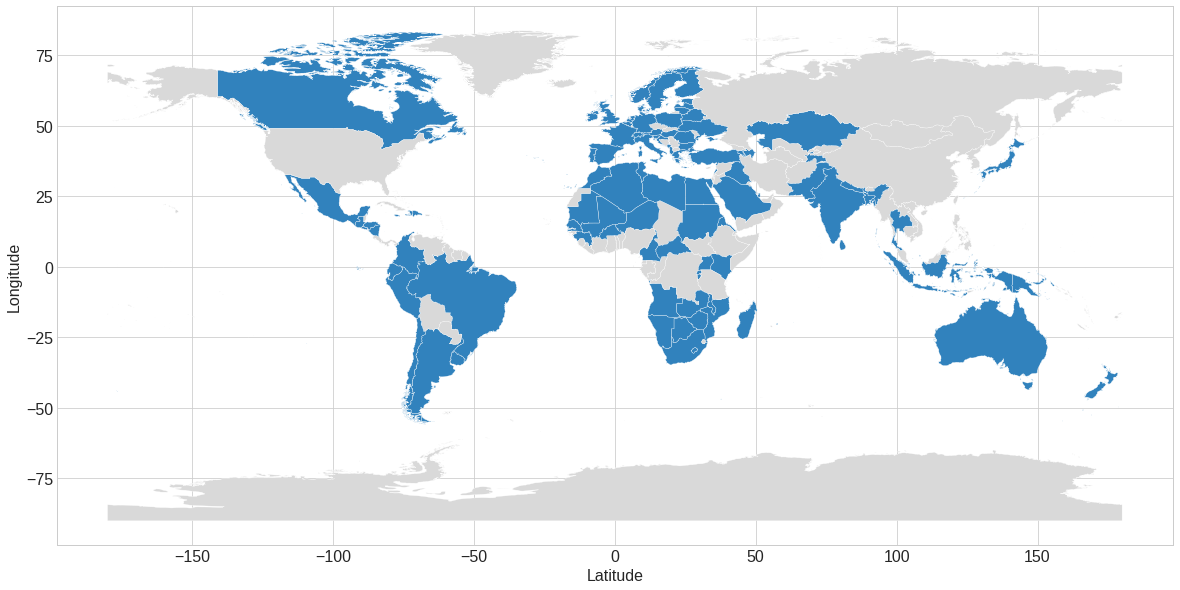

In [13]:
countries = aug_processed_cy['Area'].unique()
plot_geodata_world(countries)

## Data Visualization

Let's plot the correlation matrices for each item to see if there are features to be dropped.

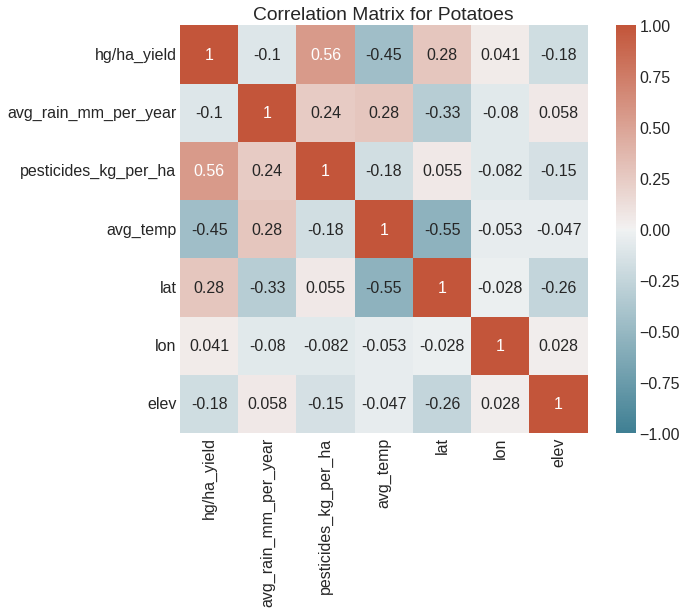

In [14]:
plot_corr_matrix(aug_processed_cy, 'Potatoes')

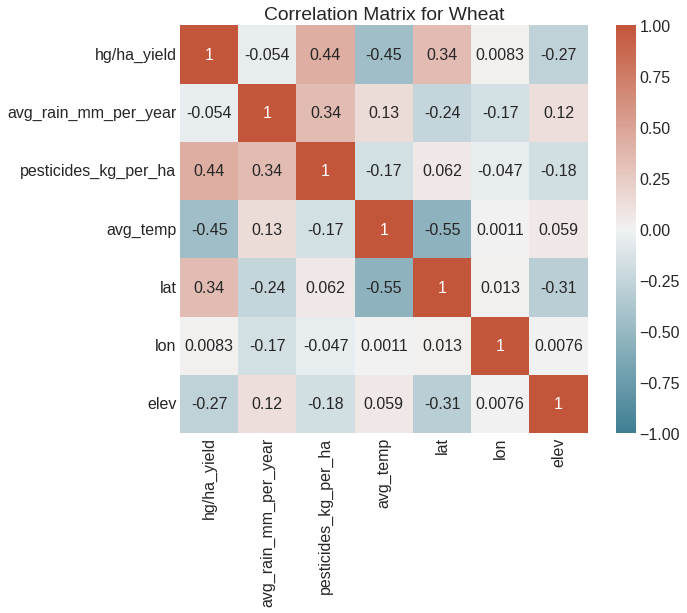

In [15]:
plot_corr_matrix(aug_processed_cy, 'Wheat')

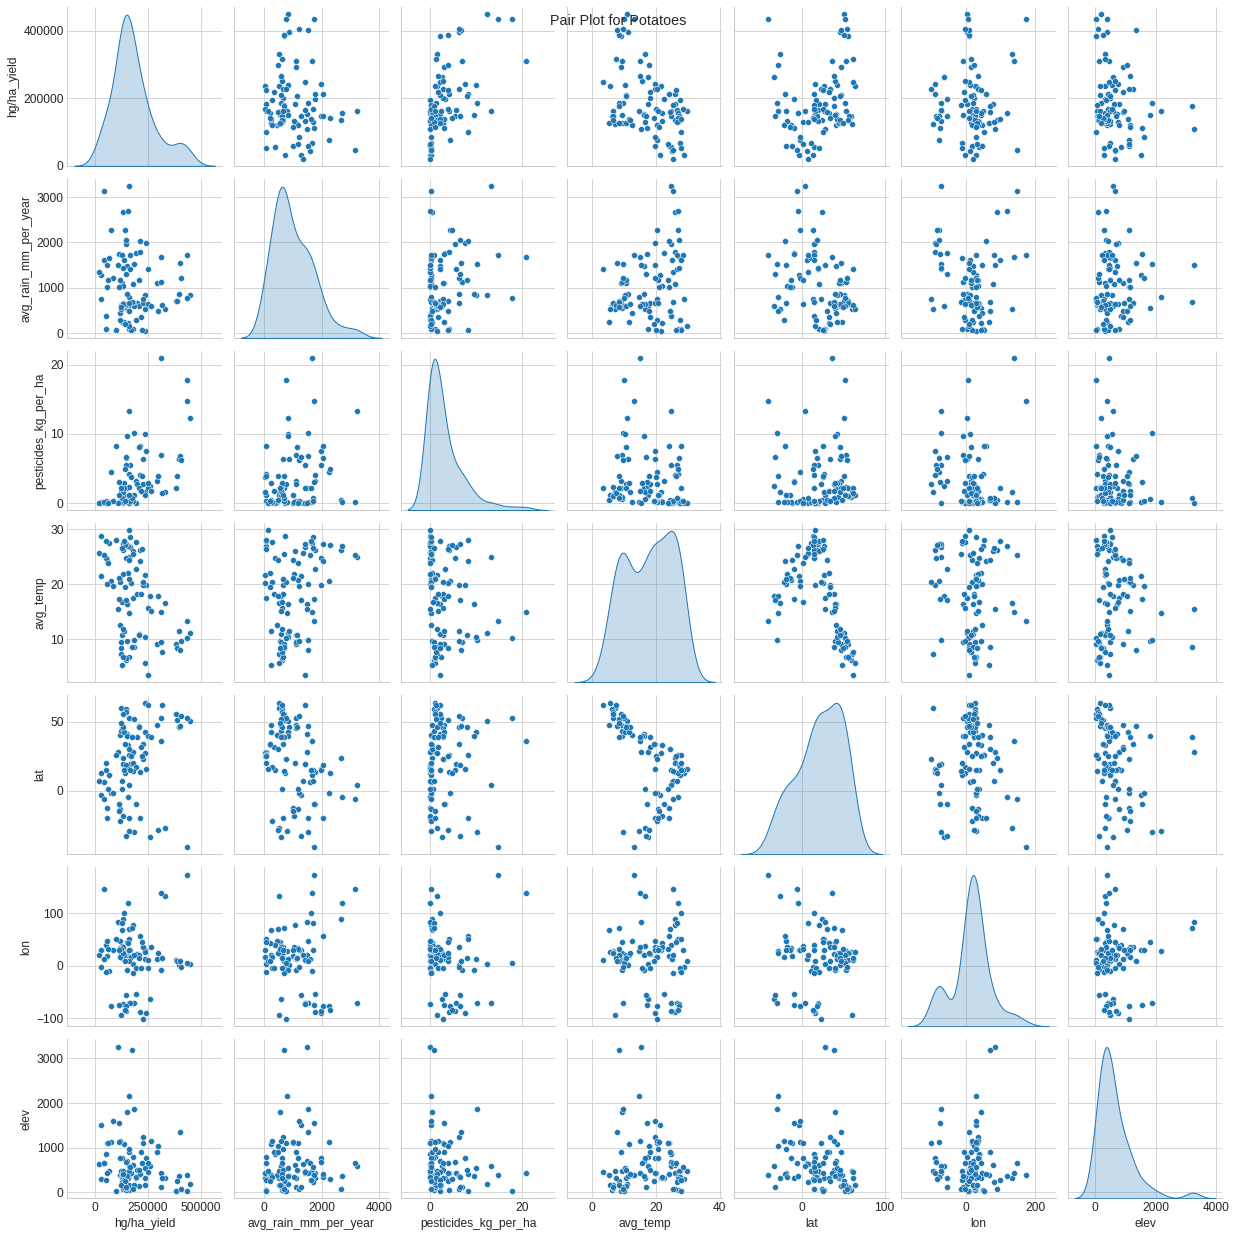

In [16]:
plot_pairplot(aug_processed_cy, 'Potatoes')

We can notice a non-linear correlation between latitude and avg. temp. as we can logically expect.
However, we decide to keep all the features.

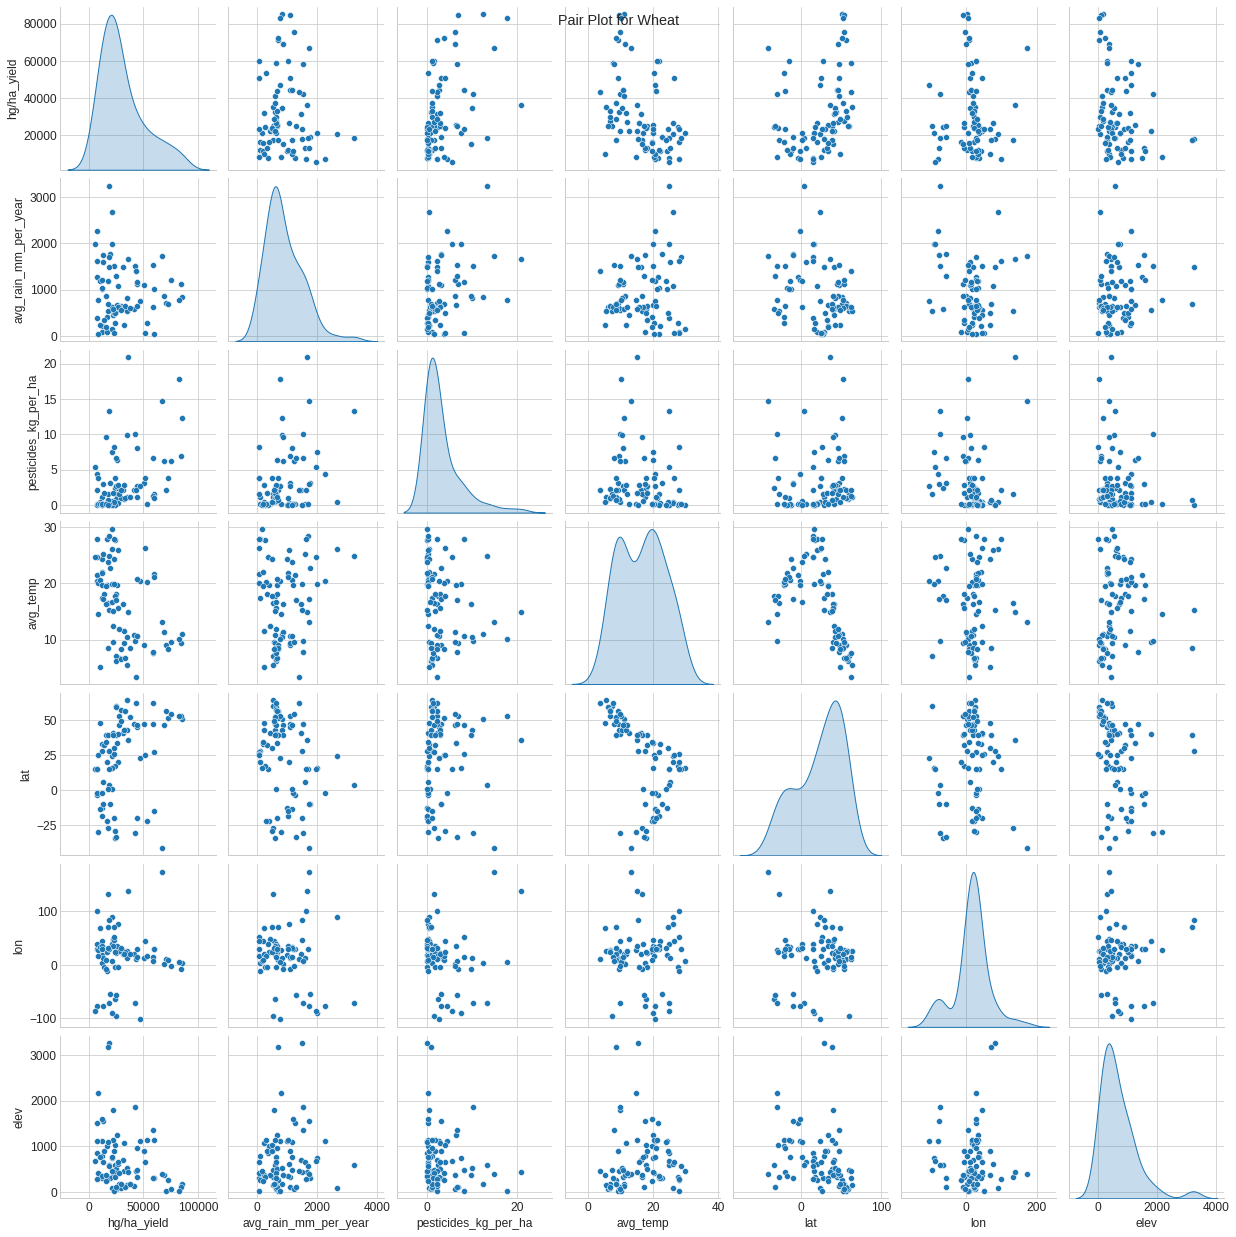

In [17]:
plot_pairplot(aug_processed_cy, 'Wheat')

In [18]:
aug_processed_cy.to_csv("data/yield_processed.csv")

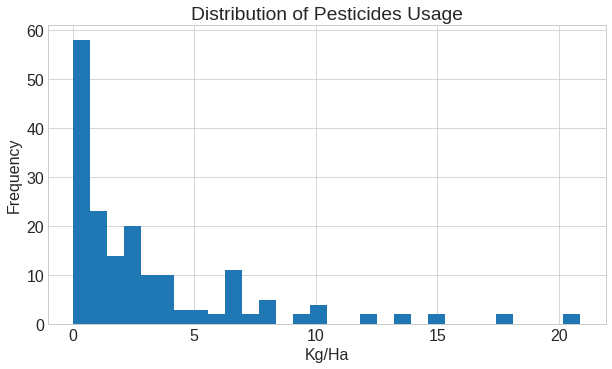

In [19]:
# Plot the distribution of pesticides usage
plt.figure(figsize=(10, 5.5))
plt.hist(aug_processed_cy['pesticides_kg_per_ha'], bins=30)
plt.title("Distribution of Pesticides Usage")
plt.xlabel("Kg/Ha"); plt.ylabel("Frequency"); plt.show()

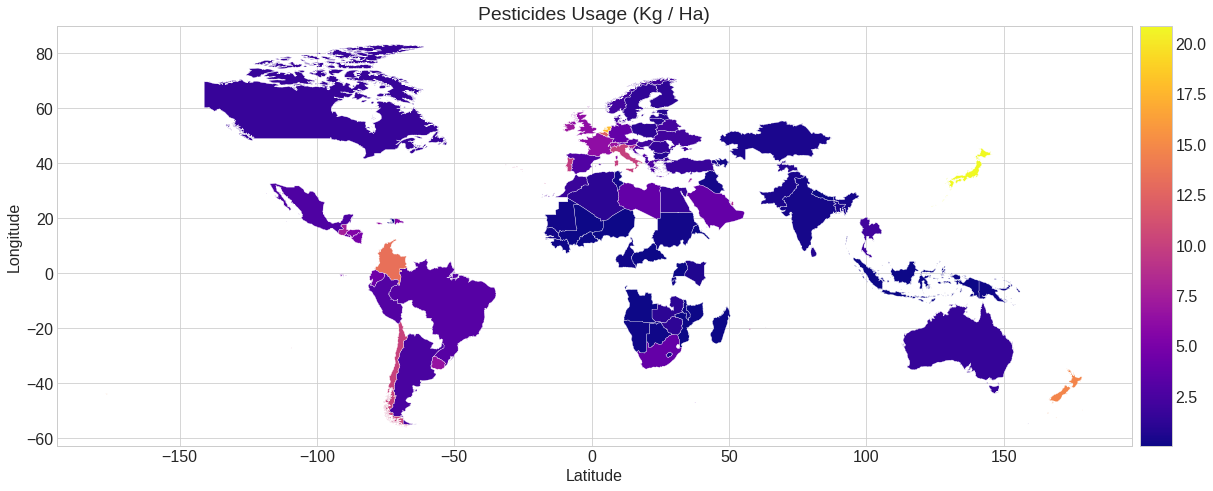

In [20]:
# Plot the distribution of pesticides usage
aug_processed_cy_all = aug_processed_cy.groupby(by='Area').mean().reset_index(drop=True)
plot_geodata_world(countries, aug_processed_cy_all['pesticides_kg_per_ha'], title='Pesticides Usage (Kg / Ha)')

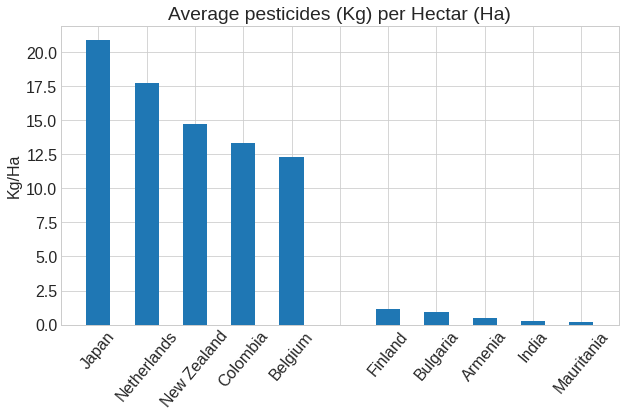

In [21]:
plot_bar_statistics('pesticides_kg_per_ha', 'Kg/Ha', 'Average pesticides (Kg) per Hectar (Ha)', q=20, y=5)

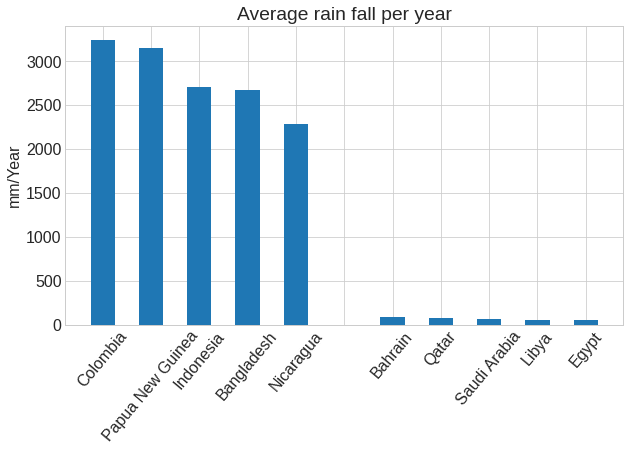

In [22]:
plot_bar_statistics('avg_rain_mm_per_year', 'mm/Year', 'Average rain fall per year')

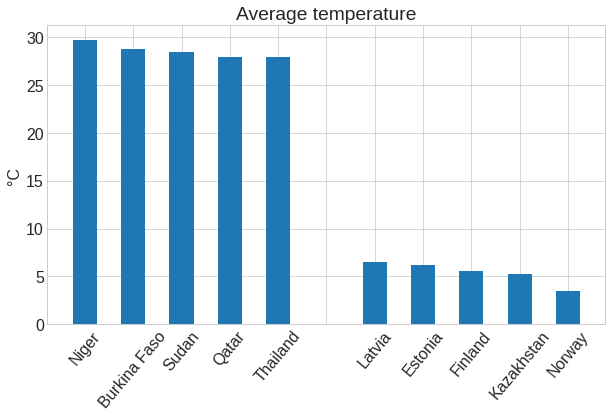

In [23]:
plot_bar_statistics('avg_temp', '°C', 'Average temperature')